In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

plt.style.use('ggplot')


In [14]:
df_users = pd.read_csv('user_snapshots.csv')

In [113]:
df_prices = df_users[['collateralName', 'oraclePrice', 'timestamp']].copy()
df_prices.drop_duplicates(inplace=True)
df_prices['timestamp'] = pd.to_datetime(df_prices['timestamp'], unit='s')
df_prices.sort_values(by=['collateralName', 'timestamp'], inplace=True)

df_prices['log_return'] = df_prices.groupby('collateralName', group_keys=False)['oraclePrice'].apply(lambda x: np.log(x / x.shift(1)))

span = 6  # 6 periods of 4 hours each

df_prices['volatility'] = df_prices.groupby('collateralName', group_keys=False)['log_return'].transform(lambda x: x.ewm(span=span).std())
df_prices.dropna(inplace=True)
df_prices.set_index(['timestamp', 'collateralName'], inplace=True)


In [114]:
df_prices

,,oraclePrice,log_return,volatility
timestamp,collateralName,,,
2023-06-26 04:19:59,WBTC,30183.386765,-0.007290,0.003111
2023-06-26 08:00:11,WBTC,30345.989406,0.005373,0.007016
2023-06-26 12:19:47,WBTC,30235.913475,-0.003634,0.005492
2023-06-26 16:09:11,WBTC,30403.283384,0.005520,0.005872
2023-06-26 20:01:11,WBTC,30133.638686,-0.008908,0.006997
...,...,...,...,...
2023-11-26 20:09:59,wstETH,2354.784779,-0.007946,0.005311
2023-11-27 04:14:11,wstETH,2350.411098,-0.001859,0.004563
2023-11-27 08:06:59,wstETH,2341.522030,-0.003789,0.003874


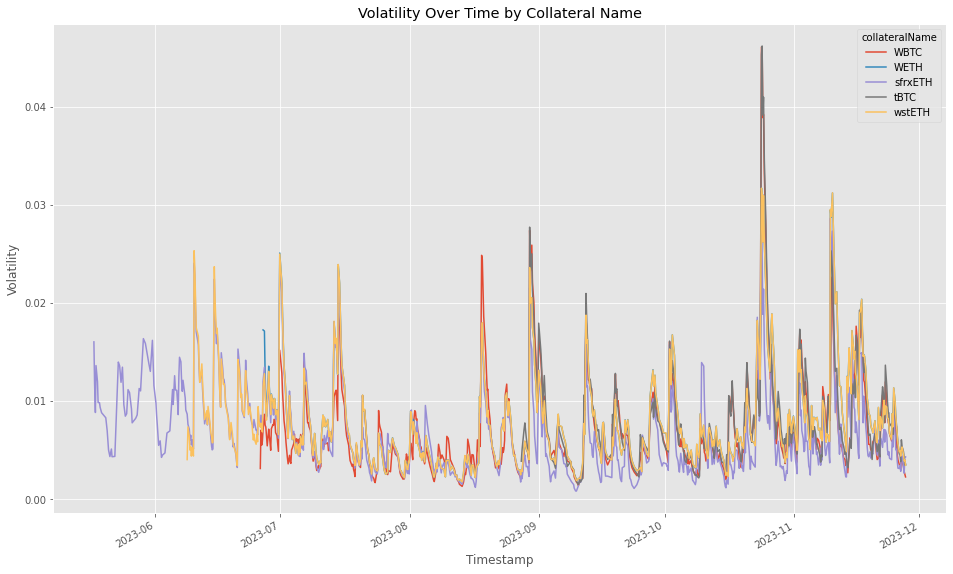

In [115]:

aggregated_df = df_prices.groupby(level=['timestamp', 'collateralName']).mean()

# Unstack the DataFrame
unstacked_df = aggregated_df['volatility'].unstack(level=-1)

# Set ggplot style and plot
plt.style.use('ggplot')
unstacked_df.plot(figsize=(16, 10))

plt.title("Volatility Over Time by Collateral Name")
plt.xlabel("Timestamp")
plt.ylabel("Volatility")
plt.show()

In [118]:
vol_df = unstacked_df.resample('D').mean()

In [122]:
vol_df['WBTC']

timestamp
2023-05-17         NaN
2023-05-18         NaN
2023-05-19         NaN
2023-05-20         NaN
2023-05-21         NaN
                ...   
2023-11-23    0.008187
2023-11-24    0.006877
2023-11-25    0.005544
2023-11-26    0.003601
2023-11-27    0.002734
Freq: D, Name: WBTC, Length: 195, dtype: float64

In [53]:
df_markets = pd.read_csv('market_snapshots.csv')
df_markets

,rate,totalCollateral,totalDebt,nLoans,timestamp,marketId,collateral,collateralName
0,0.050390,2261.142969,2.339162e+06,71,1695965891,0x8472a9a7632b173c8cf3a86d3afec50c35548e76,0xac3e018457b222d93114458476f3e3416abbe38f,sfrxETH
1,0.044063,663.782084,1.016722e+07,14,1697646323,0x1c91da0223c763d2e0173243eadaa0a2ea47e704,0x18084fba666a33d37592fa2633fd49a74dd93a88,tBTC
2,0.060351,5781.625643,6.070221e+06,115,1697397155,0xa920de414ea4ab66b97da1bfe9e6eca7d4219635,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH
3,0.030249,4538.348514,4.671262e+06,102,1695594395,0xa920de414ea4ab66b97da1bfe9e6eca7d4219635,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH
4,0.035599,1650.357214,1.589316e+06,43,1699237667,0x8472a9a7632b173c8cf3a86d3afec50c35548e76,0xac3e018457b222d93114458476f3e3416abbe38f,sfrxETH
...,...,...,...,...,...,...,...,...
17486,0.070935,2007.458787,1.974511e+06,57,1697835935,0x8472a9a7632b173c8cf3a86d3afec50c35548e76,0xac3e018457b222d93114458476f3e3416abbe38f,sfrxETH
17487,0.075877,8866.657859,8.808309e+06,73,1698382859,0xec0820efafc41d8943ee8de495fc9ba8495b15cf,0xac3e018457b222d93114458476f3e3416abbe38f,sfrxETH
17488,0.070935,2004.382940,1.973933e+06,57,1697698451,0x8472a9a7632b173c8cf3a86d3afec50c35548e76,0xac3e018457b222d93114458476f3e3416abbe38f,sfrxETH
17489,0.076901,45694.720198,6.767661e+07,410,1699781063,0x100daa78fc509db39ef7d04de0c1abd299f4c6ce,0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0,wstETH


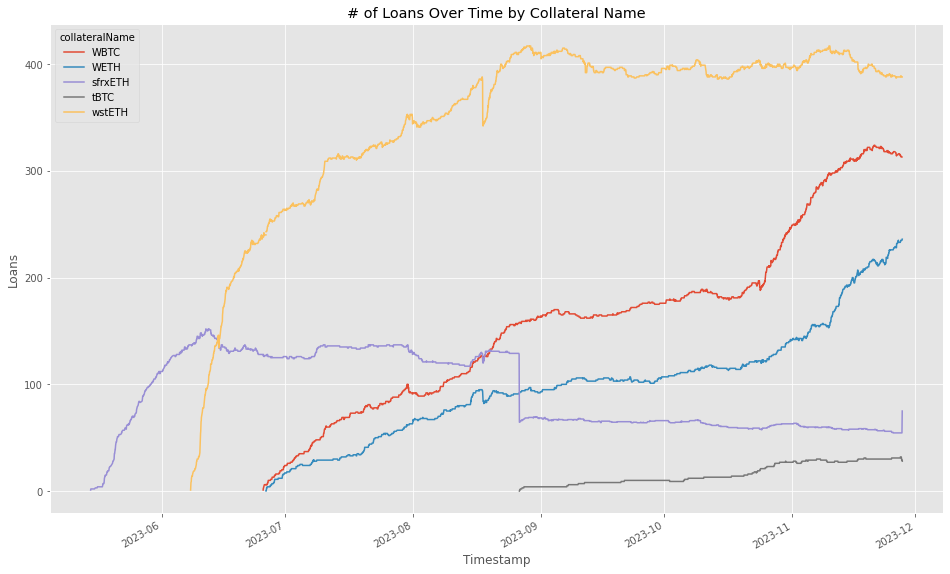

In [120]:
df_markets['timestamp'] = pd.to_datetime(df_markets['timestamp'], unit='s')
aggregated_df = df_markets[['nLoans', 'timestamp', 'collateralName']].set_index(['timestamp', 'collateralName']).groupby(level=['timestamp', 'collateralName']).mean()
unstacked_df = aggregated_df['nLoans'].unstack(level=-1)

# Set ggplot style and plot
plt.style.use('ggplot')
ax = unstacked_df.plot(figsize=(16, 10))

plt.title("# of Loans Over Time by Collateral Name")
plt.xlabel("Timestamp")
plt.ylabel("Loans")
plt.show()

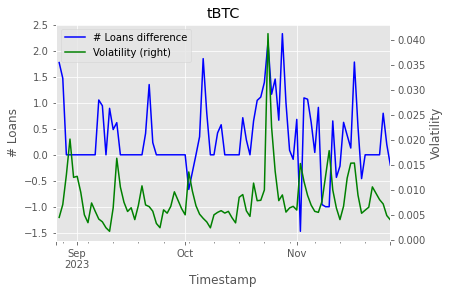

Lag 1: Spearman Correlation: 0.13795823758998735  (p: 0.18971010895825588)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.876
Date:                Wed, 29 Nov 2023   Prob (F-statistic):             0.0521
Time:                        16:01:38   Log-Likelihood:                -89.551
No. Observations:                  92   AIC:                             183.1
Df Residuals:                      90   BIC:                             188.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

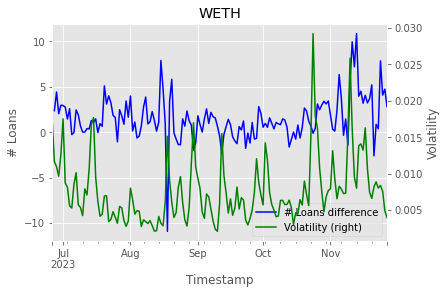

Lag 1: Spearman Correlation: 0.22455185739386524  (p: 0.005114088867488937)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     10.46
Date:                Wed, 29 Nov 2023   Prob (F-statistic):            0.00150
Time:                        16:01:42   Log-Likelihood:                -347.90
No. Observations:                 154   AIC:                             699.8
Df Residuals:                     152   BIC:                             705.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

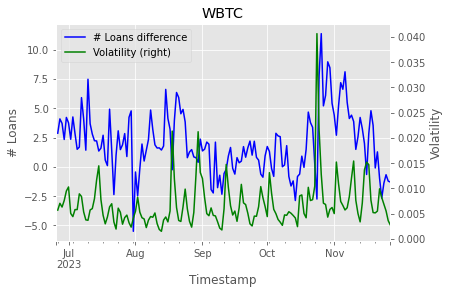

Lag 1: Spearman Correlation: 0.13299654172519448  (p: 0.10011220050873584)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     11.22
Date:                Wed, 29 Nov 2023   Prob (F-statistic):            0.00102
Time:                        16:01:43   Log-Likelihood:                -362.03
No. Observations:                 154   AIC:                             728.1
Df Residuals:                     152   BIC:                             734.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

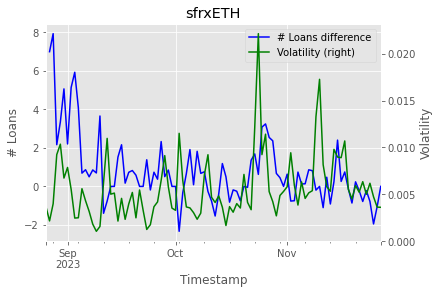

Lag 1: Spearman Correlation: -0.0734849111741258  (p: 0.4839112967183261)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.07232
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.789
Time:                        16:01:44   Log-Likelihood:                -185.07
No. Observations:                  93   AIC:                             374.1
Df Residuals:                      91   BIC:                             379.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

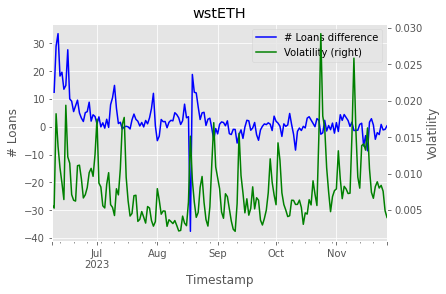

Lag 1: Spearman Correlation: -0.08625603594154892  (p: 0.26055228156106763)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.335
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.250
Time:                        16:01:45   Log-Likelihood:                -568.03
No. Observations:                 172   AIC:                             1140.
Df Residuals:                     170   BIC:                             1146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [158]:
for market in df_markets['marketId'].unique():
    if market == '0x8472a9a7632b173c8cf3a86d3afec50c35548e76':
        continue
    df = df_markets[df_markets['marketId'] == market].copy()
    collat = list(df['collateralName'])[0]
    df = df[['nLoans', 'timestamp']]
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df.set_index('timestamp', inplace=True)
    df = df.resample('D').mean()
    df['nLoans_diff'] = df['nLoans'].diff()

    ax = df['nLoans_diff'].plot(color='blue', label='# Loans difference')
    vol_df[vol_df.index >= df.index.min()][collat].dropna().plot(ax=ax, secondary_y=True, color='green', label='Volatility')

    ax.set_xlabel("Timestamp")
    ax.set_ylabel("# Loans")
    ax.right_ax.set_ylabel("Volatility")
    ax.set_title(collat)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='best')
    plt.show()

    lags = [1, 2, 3, 4]
    for lag in lags:
        df['volatility_lagged'] = vol_df[vol_df.index >= df.index.min()][collat].dropna().shift(lag)
        corr_spearman = spearmanr(df.dropna()['volatility_lagged'], df.dropna()['nLoans_diff'])
        print(f"Lag {lag}: Spearman Correlation: {corr_spearman[0]}  (p: {corr_spearman[1]})")
        X = sm.add_constant(df['volatility_lagged'].dropna())
        y = df.dropna()['nLoans_diff']
        model = sm.OLS(y, X).fit()
        print(f"{model.summary()}\n\n")
    
    max_lag = 4
    gc_test = grangercausalitytests(pd.concat([df['nLoans_diff'].dropna(), vol_df[vol_df.index >= df.index.min()][collat].dropna()], axis=1).dropna(), max_lag)

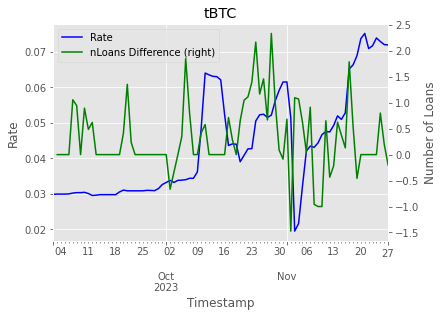

Lag 1: Spearman Correlation: 0.0012408565362057203  (p: 0.9909531034159877)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2904
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.591
Time:                        16:03:36   Log-Likelihood:                -86.223
No. Observations:                  86   AIC:                             176.4
Df Residuals:                      84   BIC:                             181.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

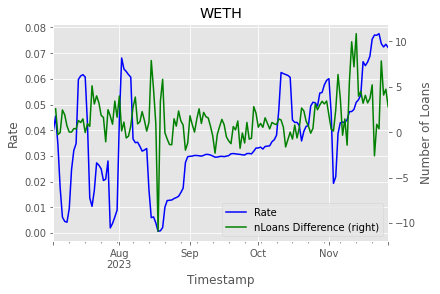

Lag 1: Spearman Correlation: 0.08059464667398387  (p: 0.33184915810753024)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.503
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.116
Time:                        16:03:36   Log-Likelihood:                -337.83
No. Observations:                 147   AIC:                             679.7
Df Residuals:                     145   BIC:                             685.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

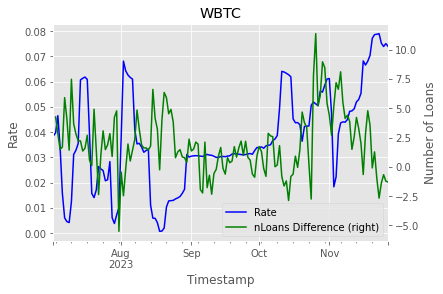

Lag 1: Spearman Correlation: -0.12549558187142082  (p: 0.1285638606958496)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.713
Date:                Wed, 29 Nov 2023   Prob (F-statistic):             0.0559
Time:                        16:03:37   Log-Likelihood:                -353.15
No. Observations:                 148   AIC:                             710.3
Df Residuals:                     146   BIC:                             716.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

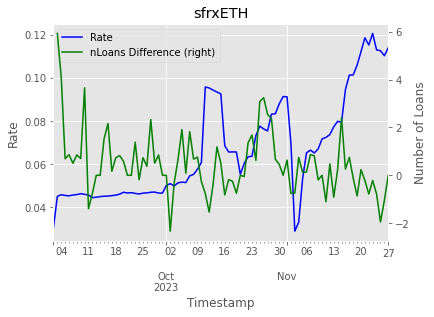

Lag 1: Spearman Correlation: -0.3548013579350114  (p: 0.000802592233897243)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     10.11
Date:                Wed, 29 Nov 2023   Prob (F-statistic):            0.00207
Time:                        16:03:38   Log-Likelihood:                -139.88
No. Observations:                  86   AIC:                             283.8
Df Residuals:                      84   BIC:                             288.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

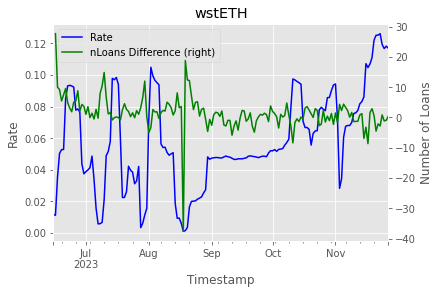

Lag 1: Spearman Correlation: -0.3284980211287374  (p: 1.6495086292643035e-05)
                            OLS Regression Results                            
Dep. Variable:            nLoans_diff   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     14.65
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           0.000184
Time:                        16:03:38   Log-Likelihood:                -504.30
No. Observations:                 165   AIC:                             1013.
Df Residuals:                     163   BIC:                             1019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [160]:
for market in df_markets['marketId'].unique():
    if market == '0x8472a9a7632b173c8cf3a86d3afec50c35548e76':
        continue
    df = df_markets[df_markets['marketId'] == market].copy()
    collat = list(df['collateralName'])[0]
    df = df[['rate', 'nLoans', 'timestamp']]
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df.set_index('timestamp', inplace=True)
    df = df.resample('D').mean()
    df = df[7:]
    df['nLoans_diff'] = df['nLoans'].diff()

    ax = df['rate'].plot(color='blue', label='Rate')
    df['nLoans_diff'].plot(ax=ax, secondary_y=True, color='green', label='nLoans Difference')

    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Rate")
    ax.right_ax.set_ylabel("Number of Loans")
    ax.set_title(collat)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='best')
    plt.show()
    #df.plot(x='timestamp', title=collat)

    lags = [1, 2, 3, 4]
    for lag in lags:
        df['interest_rate_lagged'] = df['rate'].shift(lag)
        corr_spearman = spearmanr(df.dropna()['interest_rate_lagged'], df.dropna()['nLoans_diff'])
        print(f"Lag {lag}: Spearman Correlation: {corr_spearman[0]}  (p: {corr_spearman[1]})")
        X = sm.add_constant(df['interest_rate_lagged'].dropna())
        y = df.dropna()['nLoans_diff']
        model = sm.OLS(y, X).fit()
        print(f"{model.summary()}\n\n")
    
    max_lag = 4
    gc_test = grangercausalitytests(df[['nLoans_diff', 'rate']].dropna(), max_lag)